In [1]:
import sys
sys.path += ["../24_01_05消息格式转换/"]
from main18_format_transform_weight import main
from main16_map_visualization2 import visualization

查看结果

In [2]:
def show_map(map):
    N = map.N

    for i in range(N):
        for j in range(N):
            node = map.node_matrix[i][j]
            print(node.distance, end=" ")
        print()

    print("==================================")
    for i in range(N):
        for j in range(N):
            node = map.node_matrix[i][j]
            if node.best_direction == "UP":
                print("↑", end=" ")
            elif node.best_direction == "RIGHT":
                print("→", end=" ")            
            elif node.best_direction == "DOWN":
                print("↓", end=" ")            
            elif node.best_direction == "LEFT":
                print("←", end=" ")
            else:
                print("U", end=" ")
        print()

In [3]:
# map_filename = "../24_01_05消息格式转换/main18_format_transform_weight.txt"
# map_filename = "../23_12_22路径优化/main7_map_input.txt"
map_filename = "main19_mph_map.txt"

旧格式转换思路，每个transmitter需要的格式取出现次数最多的

manhattan_scale 1
1 16
2 16
3 16
4 16
4
2 2 4 0 1 0 0 2 0 0 3 0 0 4 0 
2 0 1 1 1 0 
4 2 1 1 2 0 
2 4 1 1 3 0 
0 2 1 1 4 0 
T1: 0; tmp_cost: 0
T2: 0; tmp_cost: 0
T3: 0; tmp_cost: 0
T4: 0; tmp_cost: 0
time score: 4.0
cost score: 12
559619.185296267


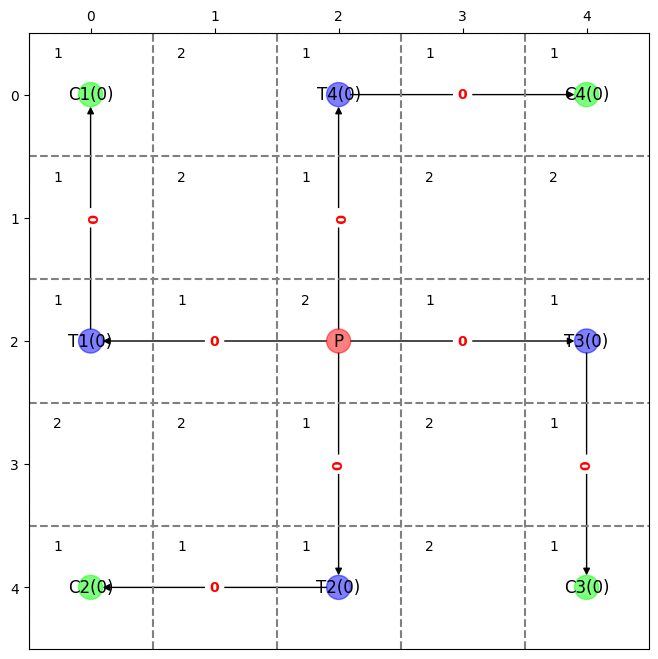

16 16 2 15 16 
15 15 1 15 16 
2 1 0 1 2 
16 15 1 15 15 
16 15 2 16 16 
↓ → ↓ ← ← 
↓ → ↓ ← ↓ 
→ → U ← ← 
↑ ↑ ↑ ↑ ↑ 
→ → ↑ ← ↑ 


In [4]:
map, provider, consumer_vector, transmitter_vector = main(conf_file=map_filename)
visualization(map, provider, consumer_vector, transmitter_vector)
show_map(map)

In [5]:
# def mph():
#     consumer_xy_list = [(consumer.x, consumer.y) for consumer in consumer_vector]
#     provider_x, provider_y = provider.x, provider.y 
#     V = [provider_x, provider_y] # 初始Provider加入组播树
#     G = []
#     shortest_path_dict = {} # 两两结点对之间的最短路径
#     for i in range(len(consumer_xy_list)):

#         new_path_dict, new_path_cost_dict = {}
#         path_dict ={
#             [(2,3), (0,0)] : [(2,3), (2,2), (1,2), (1,1), (1,0), (0,0)],
#             [(2,3), (3,1)] : [(2,3), (2,2), (3,2), (3,1)],
#             [(2,3), (1,3)] : [(2,3), (1,3)],
#         }
#         path_cost_dict = {
#             [(2,3), (0,0)] : 60,
#             [(2,3), (3,1)] : 40,
#             [(2,3), (1,3)] : 20,
#         }
#         # 选择距离组播树最近Consumer，加入组播树，直到所有的结点完成
#         # 现有Consumer无法与已有组播树相连，则及时停止


In [8]:
from queue import PriorityQueue

# 使用结点序号作为index = x*N+y
N = map.N

# 输出矩阵
def show_map(N, distance_matrix, direction_matrix):
    for i in range(N):
        for j in range(N):
            print(distance_matrix[i][j], end=" ")
        print()

    print("===============")
    for i in range(N):
        for j in range(N):
            direction = direction_matrix[i][j]
            if direction == "UP":
                print("↑", end=" ")
            elif direction == "RIGHT":
                print("→", end=" ")            
            elif direction == "DOWN":
                print("↓", end=" ")            
            elif direction == "LEFT":
                print("←", end=" ")
            else:
                print("U", end=" ")
        print()
    print("==================================")

# 获得邻居列表
def get_neighbor_list(neighbor_index):
    x, y = int(neighbor_index/N), neighbor_index%N
    neighbor_list = []
    if x > 0:
        neighbor_list.append([(x-1)*N+y, "DOWN"]) # 当前结点在邻居结点的位置
    if y < N-1:
        neighbor_list.append([x*N+(y+1), "LEFT"])
    if x < N-1:
        neighbor_list.append([(x+1)*N+y, "UP"])
    if y > 0:
        neighbor_list.append([x*N+(y-1), "RIGHT"])
    return neighbor_list

# 向源节点回溯
def traceback_path(index, source, direction_matrix):
    if index == source:
        return []
    else:
        x, y = int(index/N), index%N
        pre_index = 0 # 前驱结点序号
        if direction_matrix[x][y] == "DOWN":
            pre_index = index + N
        elif direction_matrix[x][y] == "LEFT":
            pre_index = index -1
        elif direction_matrix[x][y] == "UP":
            pre_index = index - N
        elif direction_matrix[x][y] == "RIGHT":
            pre_index = index + 1
        pre_path = traceback_path(pre_index, source, direction_matrix)
        path = pre_path + [(pre_index, index)]
        return path


# 从source执行dijkstra，返回到consumer的路径
def dijkstra(source, consumer_index_list):
    # 初始化
    distance_matrix = [[-1 for i in range(N)] for j in range(N)] # 距离矩阵
    direction_matrix = [["" for i in range(N)] for j in range(N)] # 方向矩阵用于回溯
    visited_matrix = [[False for i in range(N)] for j in range(N)] # 访问矩阵
    n_consumer = len(consumer_index_list) # 用作记录及时停止

    q = PriorityQueue()
    q.put((0, source))
    source_x, source_y = int(source/N), source%N
    distance_matrix[source_x][source_y] = 0 # 起点设置为0
    direction_matrix[source_x][source_y] = "UNKOWN"
    visited_matrix[source_x][source_y] = True

    while not q.empty():
        current_index = q.get()[1]
        current_x, current_y = int(current_index/N), current_index%N # 转化为坐标方便查找
        current_node = map.node_matrix[current_x][current_y]
        if current_index in consumer_index_list:
            # 邻居及时停止
            if not visited_matrix[current_x][current_y]:
                n_consumer -= 1
                if n_consumer == 0:
                    visited_matrix[current_x][current_y] = True
                    break
        else:
            # 更新邻居
            for neighbor_index, direction in get_neighbor_list(current_index):
                neighbor_x, neighbor_y = int(neighbor_index/N), neighbor_index%N
                neighbor_node = map.node_matrix[neighbor_x][neighbor_y]
                new_cost = distance_matrix[current_node.x][current_node.y] + neighbor_node.weight
                # TODO: 添加转弯代价
                if (distance_matrix[neighbor_x][neighbor_y] == -1) or (new_cost < distance_matrix[neighbor_x][neighbor_y]):
                    # 更新从当前结点其到的源点距离
                    priority = new_cost # TODO:A*改进
                    q.put((priority, neighbor_index))
                    distance_matrix[neighbor_x][neighbor_y] = new_cost
                    direction_matrix[neighbor_x][neighbor_y]= direction
        visited_matrix[current_x][current_y] = True
    # show_map(N, distance_matrix, direction_matrix)
    
    # 回溯找路径
    path_dict = {}
    cost_dict = {}
    for consumer_index in consumer_index_list:
        path = traceback_path(consumer_index, source, direction_matrix)
        path_dict[(source, consumer_index)] = path
        cost_dict[(source, consumer_index)] = distance_matrix[int(consumer_index/N)][consumer_index%N]
    return path_dict, cost_dict


def mph():
    # 坐标转化为序号
    consumer_index_list = [consumer.x*N+consumer.y for consumer in consumer_vector]
    provider_index = provider.x*N+provider.y 
    
    # 组播树
    V_list = [provider_index]
    G_list  = []
    new_V_list =  [provider_index] # 待计算最短距离的
    path_dict = {} # 组播树中每个中间结点到组播树外Consumer的最短路径
    path_cost_q =  PriorityQueue() # 组播树中每个中间结点到Consumer的成本优先级队列（不能只保存最短的距离）
    
    for i in range(len(consumer_index_list)):
        # 选择距离组播树最近Consumer，加入组播树，直到所有的结点完成
        # 上一次新加入的中间结点计算到组播树外Consumer的最短路径
        for new_V in new_V_list:
            new_path_dict, new_path_cost_dict = dijkstra(new_V, consumer_index_list)
            for k, v in new_path_dict.items():
                path_dict[k] = v
            for k, v in new_path_cost_dict.items():
                path_cost_q.put((v, k))
         # 第一次运行后
        # path_dict ={
        #     (13, 0) : [13, 12, 7, 6, 5, 0],
        #     (13, 16) : [13, 12, 17, 16],
        #     (13, 8) : [13, 8],
        # }
        # path_cost_q = [
        #     (20, (13, 0)),
        #     (40, (13, 16)),
        #     (60, (13, 8)),
        # ]
        # print(path_dict)
        # print(path_cost_q.queue)
                
        # 获取距离当前组播树最近的Consumer的path
        path = []
        while (not path_cost_q.empty()) and (len(path)==0):
            # 提取到一条有效路径停止
            k = path_cost_q.get()[1]
            path = path_dict[k]
        if len(path) == 0:
            # 无法往组播树里添加Consumer了, 现有Consumer无法与已有组播树相连，则及时停止
            break
        
        # 更新组播树
        new_V_list = []
        for j in range(len(path)):
            G_list.append(path[j])
            target = path[j][1]
            V_list.append(target)
            if j < len(path)-1:
                # 路径中的结点可以用来扩展组播树
                new_V_list.append(target)
        
        # 清除组播树中每个中间结点到新Consumer的最短路径
        new_consumer_index = path[-1][1]
        for k in path_dict:
            if new_consumer_index in k:
                path_dict[k] = []
        consumer_index_list.remove(new_consumer_index)
        
    print(V_list)
    print(G_list)

    # 树结构保存map对象中
    for u,v in G_list:
        u_x, u_y = int(u/N), u%N
        v_x, v_y = int(v/N), v%N
        map.node_matrix[u_x][u_y].child_xy_list.append((v_x, v_y))
        best_direction = "UNKOWN"
        if (u_x-v_x==1) and (u_y-v_y==0):
            best_direction = "DOWN"
        elif (u_x-v_x==0) and (u_y-v_y==-1):
            best_direction = "LEFT"
        elif (u_x-v_x==-1) and (u_y-v_y==0):
            best_direction = "UP"
        elif (u_x-v_x==-1) and (u_y-v_y==1):
            best_direction = "RIGHT"
        map.node_matrix[v_x][v_y].best_direction = best_direction
mph()

[12, 11, 10, 5, 0, 15, 20, 7, 2, 3, 4, 13, 14, 19, 24]
[(12, 11), (11, 10), (10, 5), (5, 0), (10, 15), (15, 20), (12, 7), (7, 2), (2, 3), (3, 4), (12, 13), (13, 14), (14, 19), (19, 24)]
